In [1]:
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import numpy as np
from PIL import Image, ImageTk, ImageFont, ImageDraw
import random

diff_cmap = plt.get_cmap('PiYG')

rmd = 'c:/Users/Laser/Documents/raw_mikro_data/'
wd = 'results/pixelburns/'
folder = 'pixelburn_patterning01/'
ranger = 0.07

In [2]:
files = os.listdir(wd + folder)
len(files)

293

In [3]:
def make_coord_list(sqr_size = 490):
    cords = []
    for i in range(0, 5):
        x = 0.5*sqr_size
        y = (-0.5*sqr_size)*i/5
        cords.append([x, y])
        cords.append([-x, y])
        cords.append([-y, x])
        cords.append([y, -x])

        x = 0.5*sqr_size
        y = (0.5*sqr_size)*i/5
        cords.append([x, y])
        cords.append([-x, y])
        cords.append([-y, x])
        cords.append([y, -x])
    return cords


def make_var_list(cords):
    return [[60*v/(490/2) for v in c] for c in cords]


def make_side_mask(c, s = 100):
    width = s
    height = s

    maska = np.zeros((448, 800))
    cx = int(maska.shape[1]/2) + 30 + c[0]
    cy = int(maska.shape[0]/2) + c[1]
    maska = cv2.rectangle(maska, (int(cx-width/2), int(cy-height/2)), (int(cx+width/2), int(cy+height/2)), 1, -1)
    
    return maska


def check_mapka_maske(mapka, mask, thresh = 0.01):
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    
    return pos/(pos+neg)

v_shot_x = 0
v_shot_y = 1
v_angle = 2
v_gain = 3  # count as in count of negative/positive values on the selected area of the map
v_ratio = 4  # check count, same as shot_count but for check map
v_validity = 5


def get_nppixel_count(masked_map, thres=0.01):
    neg = np.where(masked_map < -thres, 1, 0)
    pos = np.where(masked_map > thres, 1, 0)
    tot = np.where(masked_map != 0, 1, 0)
    dead = np.where((masked_map > -thres) & (masked_map < thres) & (masked_map != 0), 1, 0)

    return neg.sum(), pos.sum(), tot.sum(), dead.sum()


def cmap_array(arr, cmap, rng = 1, middle = 0):
     return cmap((arr/rng+1-middle/rng)/2)[:,:,:3]
    

def make_check_mask(shot_point, ang, arr, shot_size=110, check_size=40, span = 25):
    chm = np.zeros((arr.shape[0], arr.shape[1]))
    #     chm = cv2.circle(chm, shot_point, shot_size, 1, 2)
    cang = ang + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), check_size, 1, -1)

    cang = ang + span + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), int(check_size * 0.75), 1, -1)

    cang = ang - span + 180
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    chm = cv2.circle(chm, (px, py), int(check_size * 0.75), 1, -1)

    return chm


def new_validity_array(mapka,
                       direction,
                       aop = [(400, 224), (400, 400)],  # area of operation = [(x, y), (w, h)]
                       shot_size=110,
                       check_size=50,
                       count=100,
                       thres=0.03,
                       angle_count=15):
    val_arr = []

    minx = aop[0][0]-int(aop[1][0]/2)+int(shot_size)
    miny = aop[0][1]-int(aop[1][1]/2)+int(shot_size)
    maxx = aop[0][0]+int(aop[1][0]/2)-int(shot_size)
    maxy = aop[0][1]+int(aop[1][1]/2)-int(shot_size)
        
    val_array = []

    for i in range(0, count):
        shot_point = (minx + int(np.random.random() * (maxx - minx)),
                      miny + int(np.random.random() * (maxy - miny)))
        
        # get shotmask ratios
        shot_mask = np.zeros((mapka.shape[0], mapka.shape[1]))
        shot_mask = cv2.circle(shot_mask, shot_point, shot_size, 1, -1)
        shot_arr = mapka.copy() * shot_mask
        sh_neg, sh_pos, sh_tot, sh_dead = get_nppixel_count(shot_arr, thres = thres)
        if direction == 1: gain = sh_neg/sh_tot
        if direction == -1: gain = sh_pos/sh_tot
        gain *= (1-(sh_dead/sh_tot))  # leave the dead region alone!

        # get checkmask ratios for each angle
        angles = np.linspace(int(360 / angle_count), 360, angle_count)
        for ang in angles:
            chm = make_check_mask(shot_point, ang, mapka.copy(), check_size=check_size)
            ch_arr = mapka.copy() * chm
            ch_neg, ch_pos, ch_tot, ch_dead = get_nppixel_count(ch_arr, thres = thres)
            if direction == 1: ratio = ch_pos/ch_tot
            if direction == -1: ratio = ch_neg/ch_tot
            ratio *= (1-(ch_dead/ch_tot))  # leave the dead alone!
            val_array.append([shot_point[0], shot_point[1], ang, gain, ratio, gain*ratio**2])
        
    val_array = np.array(val_array)
    val_array = np.flip(val_array[np.argsort(val_array[:, 5])], axis=0)
    return val_array


def show_shot_asrgb(val, mapka, shot_size=110, check_size=50, ranger = 0.07):
    rgb_mapka = (255 * cmap_array(mapka.copy(), diff_cmap, rng=ranger)).astype(
        np.uint8)
    rgb_mapka = cv2.circle(rgb_mapka, (int(val[v_shot_x]), int(val[v_shot_y])),
                           shot_size, (0, 0, 0), 2)

    ang = val[v_angle] + 180
    dir_x = int(val[v_shot_x] - shot_size * np.cos(ang * np.pi / 180))
    dir_y = int(val[v_shot_y] - shot_size * np.sin(-ang * np.pi / 180))
    rgb_mapka = cv2.arrowedLine(rgb_mapka,
                                (int(val[v_shot_x]), int(val[v_shot_y])),
                                (dir_x, dir_y), (255, 24, 24), 3)

    rgb_mapka = draw_check_mask(rgb_mapka,
                                (int(val[v_shot_x]), int(val[v_shot_y])),
                                ang,
                                shot_size=shot_size,
                                check_size=check_size)
    return rgb_mapka


def show_pixel_asrgb(img, vrs, ranger = 0.07, check_size = 100):
    rgb_mapka = (255 * cmap_array(img.copy(), diff_cmap, rng=ranger)).astype(
            np.uint8)

    cx, cy = 400, 224
    w, h = 400, 400
    clr = (0, 0, 0)
    rgb_mapka = cv2.rectangle(rgb_mapka, (int(cx-w/2), int(cy-h/2)), (int(cx+w/2), int(cy+h/2)), clr, 2)

    cx, cy = 400+30+int(3*vrs[0]), 224+int(3*vrs[1])
    w, h = check_size, check_size
    clr = (0, 0, 190)
    rgb_mapka = cv2.rectangle(rgb_mapka, (int(cx-w/2), int(cy-h/2)), (int(cx+w/2), int(cy+h/2)), clr, 2)
    
    return rgb_mapka


def draw_check_mask(rgb, shot_point, ang, shot_size=110, check_size=50, span = 25):
    cang = ang
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), check_size, (0, 0, 0), 2)

    cang = ang + span
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), int(check_size * 0.7), (0, 0, 0), 2)

    cang = ang - span
    px = int(shot_point[0] + shot_size * np.cos(cang * np.pi / 180))
    py = int(shot_point[1] + shot_size * np.sin(-cang * np.pi / 180))
    rgb = cv2.circle(rgb, (px, py), int(check_size * 0.7), (0, 0, 0), 2)

    return rgb


def get_datasets(files):
    dates = []
    for file in files:
        dates.append(file[:19])

    dates = list(set(dates))

    all_datasets = []
    for date in dates:
        data_set = []
        for file in files:
            if file.find(date) >= 0:
                data_set.append(file)
        all_datasets.append(data_set)

    return all_datasets


def get_named(single_set):
    dictio = {}
    
    for item in single_set:
        if item.find('mapka_before') >= 0: dictio['mapka_before'] = item
    for item in single_set:
        if item.find('mapka_after') >= 0: dictio['mapka_after'] = item
    for item in single_set:
        if item.find('parameters') >= 0: dictio['parameters'] = item
            
    return dictio


def check_mapka_obsolete(mapka, thresh = 0.005):
    width = 300
    height = 300

    mask = np.zeros(mapka.shape)

    cx = int(mask.shape[0]/2)
    cy = int(mask.shape[1]/2)
    mask = cv2.rectangle(mask, (int(cy-width/2), int(cx-height/2)), (int(cy+width/2), int(cx+height/2)), 1, -1)
    
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width*height)-masked[(abs(masked) > thresh)].shape[0]
    
    return pos/(pos+neg+1), dead/(width*height)


def folder_of_tests(folder):
    files = os.listdir(wd + folder)
    all_datasets = get_datasets(files)
    
    ranger = 0.07
    for dataset in all_datasets:
        namel = dataset[0].split(' ')[:3]
        name = '%s %s %s'%(namel[0], namel[1], namel[2])

        names = get_named(dataset)

        f = open(wd + folder + names['parameters'], 'r')
        cnt = f.read()
        f.close()


        fig = plt.figure(figsize=(12, 8))

        img = np.load(wd + folder + names['mapka_before'])
        ax1 = fig.add_subplot(121)
        ch = ax1.imshow(img, cmap=diff_cmap)
        norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
        ch.set_norm(norm)

        img = np.load(wd + folder + names['mapka_after'])
        ax2 = fig.add_subplot(122)
        ch = ax2.imshow(img, cmap=diff_cmap)
        norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
        ch.set_norm(norm)

        ax2.text(900, 400, cnt)
        plt.tight_layout()

        fig.savefig(wd + '/pixelburn_results/%s.png'%name, dpi = 150)
        print(wd + '/pixelburn_results/%s.png'%name)
        plt.close()
        
        
def folder_of_patterns(folder):
    if os.path.isdir(wd + folder.replace('/', '_results/')) == False:
        os.mkdir(wd + folder.replace('/', '_results/'))
    ranger = 0.07
    files = os.listdir(wd + folder)
    xandys = []
    for file in files:
        xandy = file[file.find(' X')+1:file.find('.npy')]
        xandys.append(xandy)

    xandys = list(set(xandys))
    for xandy in xandys:
        selected = [f for f in files if f.find(xandy) >= 0]
        mapki = [f for f in selected if f.find('mapka_') >= 0]

        fig, axes = plt.subplots(1, len(mapki))
        fig.set_size_inches(6*len(mapki), 4)

        if len(mapki) == 1: axes = [axes]

        for i in range(0, len(mapki)):
            name = mapki[i]
            img = np.load(wd + folder + name)
            pos, dead = check_mapka(img, thresh = 0.005)
            ch = axes[i].imshow(img, cmap=diff_cmap)
            norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
            ch.set_norm(norm)
            axes[i].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
        fname = selected[0].replace('frame_000', 'result').replace('.npy', '.png')
        fig.savefig(wd + folder.replace('/', '_results/') + fname, dpi = 200)
        print(fname)
        plt.close()
        
        
def folder_of_patterns2(folder):
    if os.path.isdir(wd + folder.replace('/', '_results/')) == False:
        os.mkdir(wd + folder.replace('/', '_results/'))
    ranger = 0.07
    files = os.listdir(rmd + 'pixelburns/' + folder)
    xandys = []
    for file in files:
        if file.find('.npy') >= 0:
            xandy = file[file.find(' X')+1:file.find('.npy')]
            xandys.append(xandy)

    xandys = list(set(xandys))
    for xandy in xandys:
        selected = [f for f in files if f.find(xandy) >= 0]
        mapki = [f for f in selected if f.find('mapka_') >= 0]
        fig, axes = plt.subplots(2, len(mapki))
        fig.set_size_inches(6*len(mapki), 8)
        # if len(mapki) == 1: axes = [axes]

        for i in range(0, len(mapki)):
            name = mapki[i]

            # handle the parameters
            param_fpath = rmd + 'pixelburns/' + folder + name.replace('mapka', 'burnParams')
            
            if os.path.isfile(param_fpath):
                f = open(param_fpath)
                cnt = f.read().split('\n')
                f.close()
                params = {}
                for l in cnt:
#                     l = line.replace(':', '=')
                    if l.find('=') >= 0:
                        split = l.split('=')
                        params[split[0]] = split[1]

            img = np.load(rmd + 'pixelburns/' + folder + name)
            pos, dead = check_mapka(img, thresh = 0.005)

            if params['anim_type'][:-1] == 'shining-moon':
                val = [int(params['paranim_y']), int(params['paranim_x']), int(params['paranim_a'])]
                img = show_shot_asrgb(val, img)
                if len(mapki) == 1:
                    axes[0].imshow(img)
                else:                    
                    axes[0, i].imshow(img)
            if params['anim_type'][:-1] == 'pixel-burn':
                if os.path.isfile(param_fpath):
                    img = show_pixel_asrgb(img, [int(float(params['v5'])), int(float(params['v6']))])
                if len(mapki) == 1:
                    ch = axes[0].imshow(img, cmap=diff_cmap)
                else:                    
                    ch = axes[0, i].imshow(img, cmap=diff_cmap)            
                norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
                ch.set_norm(norm)
                    
            if params['anim_type'] == 'none':
                if len(mapki) == 1:
                    ch = axes[0].imshow(img, cmap=diff_cmap)
                else:                    
                    ch = axes[0, i].imshow(img, cmap=diff_cmap)                
                norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
                ch.set_norm(norm)
            
            if len(mapki) == 1:
                axes[0].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
            else:                    
                axes[0, i].text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))
            

            img = np.load(rmd + 'pixelburns/' + folder + name.replace('mapka', 'frame'))
            if len(mapki) == 1:
                axes[1].imshow(img)
            else:                    
                axes[1, i].imshow(img)            
            
            # additional info
            if os.path.isfile(param_fpath):
                text_str = ''
                if 'anim_type' in params.keys(): text_str += 'burn type = %s\n'%(params['anim_type'])
                if 'power' in params.keys(): text_str += 'laser power = %2.4f\n'%float(params['power'])
                if 'length' in params.keys(): text_str += 'duration = %2.4f\n'%float(params['length'])
                if 'size' in params.keys(): text_str += 'size = %2.4f\n'%float(params['size'])
                if 'temp' in params.keys(): text_str += 'temp = %2.4f\n'%float(params['temp'])    
                if 'comment' in params.keys(): text_str += 'comment = %s'%params['comment'] 
                if 'result' in params.keys(): text_str += 'result = %s'%params['result']
                if len(mapki) == 1:
                    axes[1].text(0, 500, text_str, va = 'top')
                else:                    
                    axes[1, i].text(0, 500, text_str, va = 'top')
                
            plt.tight_layout()

        fname = mapki[0].replace('mapka', 'result').replace('.npy', '.jpg')
        fig.savefig(wd + folder.replace('/', '_results/') + fname, dpi = 200)
        print(fname)
        plt.close()
        
        
def select_side(mapka, target, check_size = 100, side_thresh = 0.8, thresh = 0.01):
    '''target = 1 or -1'''
    cords = make_coord_list()
    var_list = make_var_list(cords)
    posnegs = []
    for i in range(0, len(cords)):
        maska = make_side_mask(cords[i], s = check_size)
        posnegs.append(check_mapka_maske(mapka, maska, thresh = thresh))
        
    if target == 1:
        if max(posnegs) > side_thresh:
            ind = posnegs.index(max(posnegs))
            return var_list[ind]
        else:
            return [999, 999]
    if target == -1:
        if min(posnegs) < side_thresh:
            ind = posnegs.index(min(posnegs))
            return var_list[ind]
        else:
            return [999, 999]
    
    
def check_mapka(mapka, size = 400, thresh = 0.005):
    width = size
    height = size

    mask = np.zeros(mapka.shape)

    cx = int(mask.shape[0]/2)
    cy = int(mask.shape[1]/2)
    mask = cv2.rectangle(mask, (int(cy-width/2), int(cx-height/2)), (int(cy+width/2), int(cx+height/2)), 1, -1)
    
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width*height)-masked[(abs(masked) > thresh)].shape[0]
    
    return pos/(pos+neg+1), dead/(width*height)

In [4]:
folder_of_patterns2('test3/')

19-04-2023 15.26.54 test3 result_000 P85.0 X0.750 Y0.250.jpg
19-04-2023 14.44.33 test3 result_000 P85.0 X0.000 Y0.000.jpg
19-04-2023 15.10.55 test3 result_000 P85.0 X0.000 Y0.250.jpg
19-04-2023 15.01.22 test3 result_000 P85.0 X0.500 Y0.000.jpg
19-04-2023 15.18.26 test3 result_000 P85.0 X0.250 Y0.250.jpg
19-04-2023 15.30.46 test3 result_000 P85.0 X0.000 Y0.500.jpg
19-04-2023 15.06.05 test3 result_000 P85.0 X0.750 Y0.000.jpg
19-04-2023 15.23.08 test3 result_000 P85.0 X0.500 Y0.250.jpg
19-04-2023 14.51.07 test3 result_000 P85.0 X0.250 Y0.000.jpg


In [4]:
files = [f for f in os.listdir(rmd) if f.find('mapka') >= 0]
len(files)

3

01-04-2022 15.36.41 SMP147 mapka_000 P85.0 X0.250 Y-0.000.npy


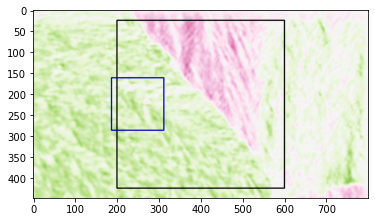

In [6]:
f_num = 2
mapka = np.load(rmd + files[f_num])
print(files[f_num])

vrs = select_side(mapka, 1, check_size = 125)
rgb_mapka = show_pixel_asrgb(mapka, vrs, check_size = 125)

plt.imshow(rgb_mapka)

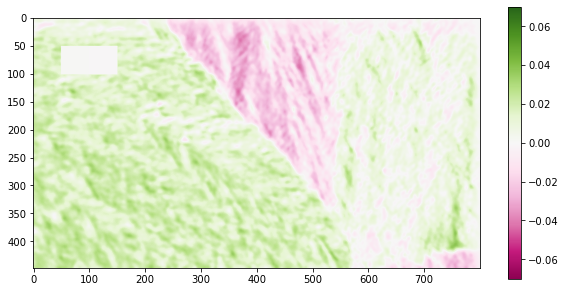

In [13]:
thresh = 0.001
mapka2 = mapka.copy()
mapka2[abs(mapka2) < thresh] = 0

mapka2 = cv2.rectangle(mapka2, (50, 50), (100, 100), thresh, -1)
mapka2 = cv2.rectangle(mapka2, (100, 50), (150, 100), -thresh, -1)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
ch = ax1.imshow(mapka2, cmap=diff_cmap)
norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
ch.set_norm(norm)

fig.colorbar(ch, ax=ax1)

0.08471676453706566


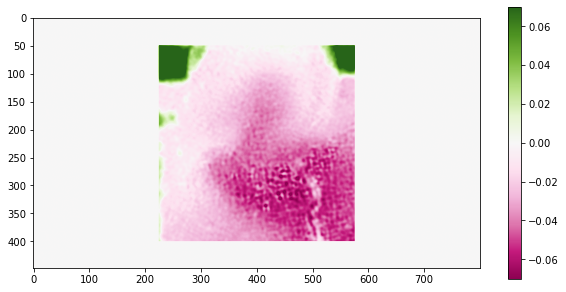

In [146]:
pos_coverage, dead, maske = check_mapka(mapka, thresh = thresh, size = 350)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
ch = ax1.imshow(maske, cmap=diff_cmap)
norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
ch.set_norm(norm)

fig.colorbar(ch, ax=ax1)
print(pos_coverage)

In [131]:
pos_coverage

0.1562547904850137

In [79]:
file = '11-03-2022 00.33.35 SMP136 mapka_004 P80.0 X1.250 Y1.500.npy'
img = np.load(rmd + 'new_patterning04/' + file)

In [80]:
f = open(rmd + 'new_patterning04/' + file.replace('mapka', 'burnParams'))
cnt = f.read().split('\n')
f.close()
params = {}
for line in cnt:
    if line.find('=') >= 0:
        split = line.split('=')
        params[split[0]] = split[1]
params

{'anim_type': 'pixel-burn4',
 'v0': '0.0000',
 'v1': '1.5500',
 'v2': '0.1000',
 'v3': '0.7500',
 'v4': '1.4500',
 'v5': '0.0000',
 'v6': '60.0000',
 'length': '40.0000',
 'power': '5.2000',
 'size': '300',
 'temp': '107',
 'paranim_x': '224',
 'paranim_y': '400',
 'paranim_a': '0',
 'direction': '1'}

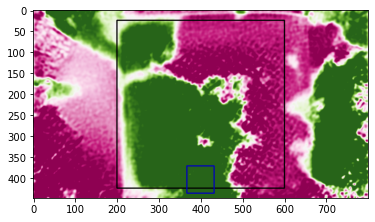

In [85]:
rgb = show_pixel_asrgb(img, [int(float(params['v5'])), int(float(params['v6']))])
plt.imshow(rgb)

In [38]:
f = open(wd + 'new_patterning01/' + file.replace('mapka', 'burnParams'))
cnt = f.read().split('\n')
f.close()

{'anim_type': 'shining-moon1',
 'v0': '0.0000',
 'v1': '1.5500',
 'v2': '0.1000',
 'v3': '0.7500',
 'v4': '1.4500',
 'v5': '999.0000',
 'v6': '999.0000',
 'length': '30.0000',
 'power': '7.0000',
 'size': '90',
 'temp': '105',
 'paranim_x': '312',
 'paranim_y': '377',
 'paranim_a': '24'}

Text(0, -20, 'green factor = 0.1626, dead = 0.0299')

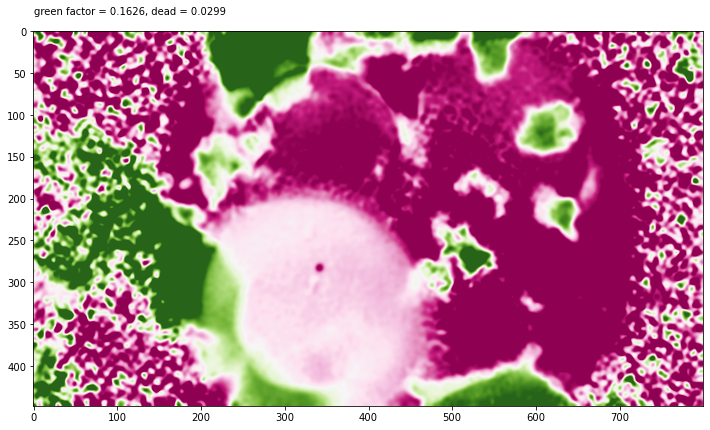

In [126]:
file = '10-03-2022 18.03.52 SMP136 mapka_005 P80.0 X0.750 Y0.250.npy'
img = np.load(wd + 'new_patterning02/' + file)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
ch = ax1.imshow(img, cmap=diff_cmap)
norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
ch.set_norm(norm)

pos, dead = check_mapka(img, thresh = 0.005)
ax1.text(0, -20, 'green factor = %2.4f, dead = %2.4f'%(pos, dead))

In [162]:
aop = [(400, 224), (400, 400)]
val_arr = new_validity_array(img, -1, shot_size = 90, aop = aop, count = 50)

0
[3.10000000e+02 1.33000000e+02 1.92000000e+02 6.81952146e-02
 8.42745335e-01 4.84335848e-02]


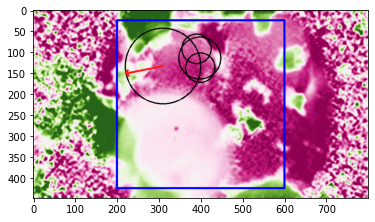

In [163]:
i = 0
rgb = show_shot_asrgb(val_arr[i], img, shot_size = 90)
stp = (int(aop[0][0]-aop[1][0]/2), int(aop[0][1]-aop[1][1]/2))
end = (int(aop[0][0]+aop[1][0]/2), int(aop[0][1]+aop[1][1]/2))
rgb = cv2.rectangle(rgb, stp, end, (0, 0, 255), 3)
plt.imshow(rgb)
print(i)
print(val_arr[i])

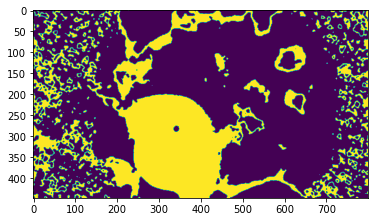

In [144]:
plt.imshow(np.where((img<0.03) & (img>-0.03), 1, 0))

In [42]:
i = 0

[-245.0, -0.0]
0.9647555468289809


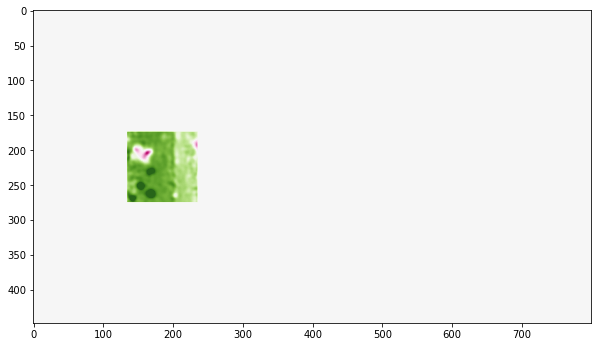

In [44]:
maska = make_side_mask(cords[i])
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(111)
ch = ax1.imshow(img*maska, cmap=diff_cmap)
norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
ch.set_norm(norm)
print(cords[i])
print(check_mapka_maske(img, maska))
if i < len(cords): i += 1

In [180]:
def select_side(mapka, target):
    '''target = 1 or -1'''
    cords = make_coord_list()
    var_list = make_var_list(cords)
    posnegs = []
    for i in range(0, len(cords)):
        maska = make_side_mask(cords[i])
        posnegs.append(check_mapka_maske(mapka, maska))
        
    if target == 1:
        ind = posnegs.index(max(posnegs))
        return var_list[ind]
    if target == -1:
        ind = posnegs.index(min(posnegs))
        return var_list[ind]
    
    
def check_mapka(mapka, thresh = 0.005):
    width = 300
    height = 300

    mask = np.zeros(mapka.shape)

    cx = int(mask.shape[0]/2)
    cy = int(mask.shape[1]/2)
    mask = cv2.rectangle(mask, (int(cy-width/2), int(cx-height/2)), (int(cy+width/2), int(cx+height/2)), 1, -1)
    
    masked = mapka*mask
    
    pos = masked[masked > thresh].shape[0]
    neg = masked[masked < -thresh].shape[0]
    dead = (width*height)-masked[(abs(masked) > thresh)].shape[0]
    
    return pos/(pos+neg+1), dead/(width*height)

In [48]:
posnegs.index(max(posnegs))

10

In [159]:
files = [f for f in os.listdir(wd + 'pixelburn_patterning06/') if f.find('mapka')>=0]

In [160]:
n = 0

In [187]:


for n in range(0, len(files)):
    img = np.load(wd + 'pixelburn_patterning06/' + files[n])
    file = files[n]

    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(111)
    ch = ax1.imshow(img, cmap=diff_cmap)
    norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
    ch.set_norm(norm)
    val, dead = check_mapka(img, thresh = 0.005)
    ax1.text(10, -10, 'gf = %2.4f, dead = %2.4f'%(val, dead))
    plt.close()
    fig.savefig('temp2/%s'%(file.replace('.npy', '.png')))
    print(file.replace('.npy', '.png'))

07-03-2022 10.49.52 SMP131 mapka_000 P80.0 X0.000 Y0.000.png
07-03-2022 10.50.00 SMP131 mapka_000 P80.0 X0.250 Y0.000.png
07-03-2022 10.51.03 SMP131 mapka_001 P80.0 X0.250 Y0.000.png
07-03-2022 10.52.06 SMP131 mapka_002 P80.0 X0.250 Y0.000.png
07-03-2022 10.53.08 SMP131 mapka_003 P80.0 X0.250 Y0.000.png
07-03-2022 10.53.16 SMP131 mapka_000 P80.0 X0.500 Y0.000.png
07-03-2022 10.54.19 SMP131 mapka_001 P80.0 X0.500 Y0.000.png
07-03-2022 10.55.22 SMP131 mapka_002 P80.0 X0.500 Y0.000.png
07-03-2022 10.55.29 SMP131 mapka_000 P80.0 X0.750 Y0.000.png
07-03-2022 10.56.32 SMP131 mapka_001 P80.0 X0.750 Y0.000.png
07-03-2022 10.57.36 SMP131 mapka_002 P80.0 X0.750 Y0.000.png
07-03-2022 10.57.46 SMP131 mapka_000 P80.0 X0.000 Y0.250.png
07-03-2022 10.58.49 SMP131 mapka_001 P80.0 X0.000 Y0.250.png
07-03-2022 10.59.52 SMP131 mapka_002 P80.0 X0.000 Y0.250.png
07-03-2022 11.00.55 SMP131 mapka_003 P80.0 X0.000 Y0.250.png
07-03-2022 11.01.57 SMP131 mapka_004 P80.0 X0.000 Y0.250.png
07-03-2022 11.02.05 SMP1

Text(10, -10, 'gf = 0.4005, dead = 0.1187')

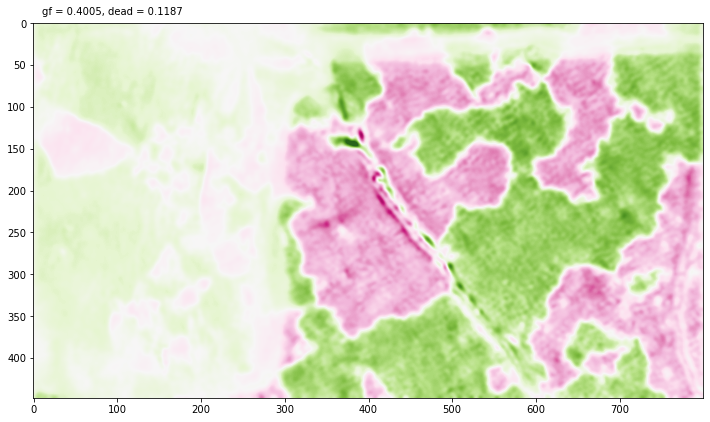

In [200]:
file = '07-03-2022 11.17.27 SMP131 mapka_000 P80.0 X0.500 Y0.500.npy'

img = np.load(wd + 'pixelburn_patterning06/' + file)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)
ch = ax1.imshow(img, cmap=diff_cmap)
norm = mpl.colors.Normalize(vmin=-ranger, vmax=ranger)
ch.set_norm(norm)
val, dead = check_mapka(img, thresh = 0.005)
ax1.text(10, -10, 'gf = %2.4f, dead = %2.4f'%(val, dead))

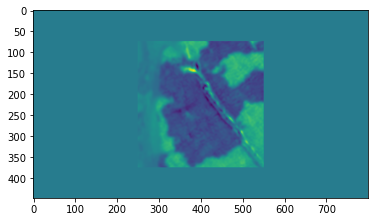

In [182]:
plt.imshow(masked)

In [151]:
dead.shape[0]

85530

In [123]:
300*300

90000

In [219]:
img = Image.open('patterns/smile.png')
arr = np.array(img)
current_pattern = arr[:,:,0]/255

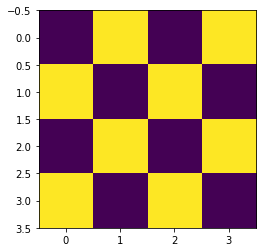

In [221]:
plt.imshow(current_pattern)

In [222]:
def get_pattern_pixel(pattern, pixel):
    cols = pattern.shape[1]
    row = int((pixel-pixel%cols)/cols)
    col = int(pixel%cols)
    if pixel < (pattern.shape[0]*pattern.shape[1]):
        return pattern[col, row], row, col
    else:
        return -1, row, col

In [224]:
for i in range(0, current_pattern.shape[0]*current_pattern.shape[1]):
    color, row, col = get_pattern_pixel(current_pattern, i)
    print('%d. C=%d, row=%2.4f, col=2.4f'%(color, row, col))

0. C=0, row=0.0000, col=2.4f
1. C=0, row=1.0000, col=2.4f
0. C=0, row=2.0000, col=2.4f
1. C=0, row=3.0000, col=2.4f
1. C=1, row=0.0000, col=2.4f
0. C=1, row=1.0000, col=2.4f
1. C=1, row=2.0000, col=2.4f
0. C=1, row=3.0000, col=2.4f
0. C=2, row=0.0000, col=2.4f
1. C=2, row=1.0000, col=2.4f
0. C=2, row=2.0000, col=2.4f
1. C=2, row=3.0000, col=2.4f
1. C=3, row=0.0000, col=2.4f
0. C=3, row=1.0000, col=2.4f
1. C=3, row=2.0000, col=2.4f
0. C=3, row=3.0000, col=2.4f


In [25]:
burn_hist_anims = ['pix', 'pix', 'kolo']
burn_hist_gfs = [0.23, 0.24, 0.2392]

In [26]:
def should_try_kolo(anim_hist, gfs_hist):
    cur = len(anim_hist)-1
    print(cur)
    if cur < 2: return False
    if anim_hist[cur] == 'pix' and anim_hist[cur-1] == 'pix' and anim_hist[cur-2] == 'pix':
        if gfs_hist[cur]-gfs_hist[cur-1] < 0.05 and gfs_hist[cur-1]-gfs_hist[cur-2] < 0.05:
            return True
    return False

In [27]:
should_try_kolo(burn_hist_anims, burn_hist_gfs)

2


False

In [97]:
laser_function = '7.5-(N/8)*(N<4)-(4/8)*(N>=4)'

In [98]:
for i in range(0, 20):
    print('%d: %2.4f'%(i, eval(laser_function.replace('N', str(i)))))

0: 7.5000
1: 7.3750
2: 7.2500
3: 7.1250
4: 7.0000
5: 7.0000
6: 7.0000
7: 7.0000
8: 7.0000
9: 7.0000
10: 7.0000
11: 7.0000
12: 7.0000
13: 7.0000
14: 7.0000
15: 7.0000
16: 7.0000
17: 7.0000
18: 7.0000
19: 7.0000


In [8]:
'jamnik = %s'%(1==1)

'jamnik = True'